# Motivation : 
 - Train Deep Neural Network.
 - Compress Using the chipnet algorithm from prune. 

In [1]:
!git clone https://github.com/transmuteAI/trailmet.git

Cloning into 'trailmet'...
remote: Enumerating objects: 1643, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 1643 (delta 25), reused 101 (delta 23), pack-reused 1533
Receiving objects: 100% (1643/1643), 2.46 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (925/925), done.


### Import Important Libraries

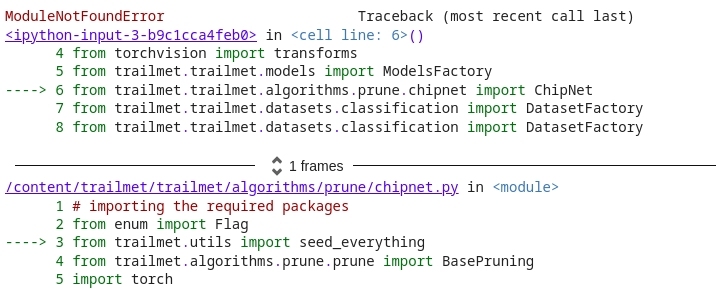

**Note** : if you get error like above then do following.
- Firstly click on /content/traimet/trailmet/algorithms/prune/chipnet.py.
- change some directory call add 
- **from trailmet.trailmet.utils import seed_everyting.**.
- **from trailmet.trailmet.algorithms.prune.prune import BasePruning**

In [2]:
# load the required packages
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from trailmet.trailmet.datasets.classification import DatasetFactory

In [3]:
root_dir = "/content/Dataset"

In [4]:
train_transform = transforms.Compose(
[transforms.ToTensor()])

val_transform = transforms.Compose(
[transforms.ToTensor()])

test_transform = transforms.Compose(
[transforms.ToTensor()])

input_transforms = {
    'train': train_transform, 
    'val': val_transform, 
    'test': test_transform}

target_transforms = {
    'train': None, 
    'val': None, 
    'test': None}

In [5]:
cifar_dataset = DatasetFactory.create_dataset(name = 'CIFAR10', 
                                        root = root_dir,
                                        split_types = ['train', 'val', 'test'],
                                        val_fraction = 0.2,
                                        transform = input_transforms,
                                        target_transform = target_transforms
                                        )

100%|██████████| 170498071/170498071 [00:02<00:00, 84790946.90it/s]


Extracting /content/Dataset/cifar-10-python.tar.gz to /content/Dataset
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# getting the size of the different splits of the data
print('Train samples: ',cifar_dataset['info']['train_size'])
print('Val samples: ',cifar_dataset['info']['val_size'])
print('Test samples: ',cifar_dataset['info']['test_size'] )

Train samples:  40000
Val samples:  10000
Test samples:  10000


In [7]:
# Construct dataloaders
train_loader = torch.utils.data.DataLoader(
        cifar_dataset['train'], batch_size=64, 
        sampler=cifar_dataset['train_sampler'],
        num_workers=0
    )
val_loader = torch.utils.data.DataLoader(
        cifar_dataset['val'], batch_size=64, 
        sampler=cifar_dataset['val_sampler'],
        num_workers=0
    )
test_loader = torch.utils.data.DataLoader(
        cifar_dataset['test'], batch_size=64, 
        sampler=cifar_dataset['test_sampler'],
        num_workers=0
    )

print('No. of training batches: ', len(train_loader))
print('No. of validation batches: ', len(val_loader))
print('No. of test batches: ', len(test_loader))

No. of training batches:  625
No. of validation batches:  157
No. of test batches:  157


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


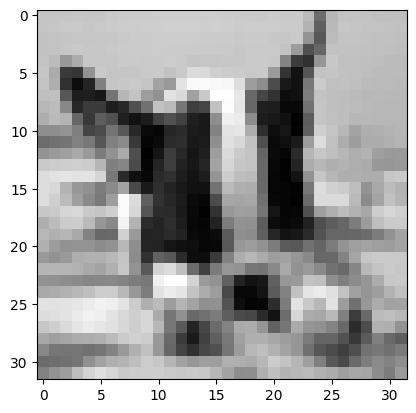

Label: 9


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[7,0,:,:].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [32]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [35]:
# load the Cifar10 dataset, 50,000 training images and 10,000 test images (here used as validation data)
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [37]:
# weights are initialized as per the he et al. method
initializer = K.initializers.he_normal()
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
model = K.applications.DenseNet201(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(224, 224, 3),
                                   pooling='max',
                                   classes=1000)
# make the weights and biases of the base model non-trainable by "freezing" each layer of the DenseNet201 network
for layer in model.layers:
    layer.trainable = False
output = model.layers[-1].output
# reshape the output feature map of the base model before passing the data on to the Dense layers of the classifier head
flatten = K.layers.Flatten()
output = flatten(output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=input_tensor, outputs=output)

74836368/74836368 [==============================] - 0s 0us/step


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [38]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

In [39]:
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [41]:
train_datagen = K.preprocessing.image.ImageDataGenerator( horizontal_flip=True,)
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_datagen = K.preprocessing.image.ImageDataGenerator(horizontal_flip=True,)
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32)
train_steps_per_epoch = x_train.shape[0] // 32
val_steps_per_epoch = x_test.shape[0] // 32
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=20,
                    shuffle=True,
                    callbacks=[lr_reduce, early_stop, checkpoint],
                    verbose=1)

Epoch 1/20
1562/1562 [==============================] - ETA: 0s - loss: 3.5030 - accuracy: 0.7160
Epoch 1: val_accuracy improved from -inf to 0.86278, saving model to cifar10.h5
1562/1562 [==============================] - 319s 195ms/step - loss: 3.5030 - accuracy: 0.7160 - val_loss: 2.2447 - val_accuracy: 0.8628 - lr: 1.0000e-04
Epoch 2/20
1562/1562 [==============================] - ETA: 0s - loss: 2.0436 - accuracy: 0.8413
Epoch 2: val_accuracy improved from 0.86278 to 0.88532, saving model to cifar10.h5
1562/1562 [==============================] - 260s 166ms/step - loss: 2.0436 - accuracy: 0.8413 - val_loss: 1.6439 - val_accuracy: 0.8853 - lr: 1.0000e-04
Epoch 3/20
1562/1562 [==============================] - ETA: 0s - loss: 1.4934 - accuracy: 0.8690
Epoch 3: val_accuracy improved from 0.88532 to 0.89153, saving model to cifar10.h5
1562/1562 [==============================] - 302s 194ms/step - loss: 1.4934 - accuracy: 0.8690 - val_loss: 1.2317 - val_accuracy: 0.8915 - lr: 1.0000e-0

In [42]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 43s 138ms/step - loss: 0.5119 - accuracy: 0.9005


[0.5118525624275208, 0.9004999995231628]

In [43]:
import torch
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from trailmet.trailmet.models import ModelsFactory
from trailmet.trailmet.algorithms.prune.chipnet import ChipNet
from trailmet.trailmet.datasets.classification import DatasetFactory
import yaml

In [44]:
root = "/content/trailmet/experiments/pruning/chipnet"

In [45]:
with open(os.path.join(root, "chipnet.yaml"), 'r') as stream:
    data_loaded = yaml.safe_load(stream)
print(data_loaded)

{'CHIPNET_ARGS': {'BUDGET_TYPE': 'channel_ratio', 'TARGET_BUDGET': 0.5, 'BUDGET_LOSS_WEIGHTAGE': 30, 'CRISPNESS_LOSS_WEIGHTAGE': 10, 'BETA_INCREMENT': 5, 'GAMMA_INCREMENT': 2, 'STEEPNESS': 100}, 'PRETRAIN': {'EPOCHS': 1, 'TEST_ONLY': False, 'OPTIMIZER': 'SGD', 'LR': 0.05, 'SCHEDULER_TYPE': 1, 'WEIGHT_DECAY': 0.001}, 'PRUNE': {'EPOCHS': 1, 'TEST_ONLY': False, 'OPTIMIZER': 'SGD', 'LR': 0.05, 'WEIGHT_DECAY': 0.001}, 'FINETUNE': {'EPOCHS': 2, 'TEST_ONLY': False, 'OPTIMIZER': 'SGD', 'LR': 0.05, 'SCHEDULER_TYPE': 1, 'WEIGHT_DECAY': 0.001}}


In [46]:
a = ChipNet(model, {'train': train_loader, 'val': val_loader, 'test': test_loader}, **data_loaded)

In [47]:
a.compress_model()

AttributeError: ignored

# Conclusion :
#### I had try to train neural network and then compress it using algorithm but. these algorithm only used for pretrain model. if we train model manually and then try to compress then we get and  error where **functional object has no attribute 'to'**
   In the next notebook we had compress the model for two pretrained model **RESNET50 and RESNET18** .